# RNN vs Longstaff-Schwartz: GBM Arithmetic Basket Option Pricing Comparison

This notebook compares the performance of Neural Network (RNN-based) and traditional Longstaff-Schwartz Monte Carlo methods for pricing American arithmetic basket options under Geometric Brownian Motion (GBM). We use the same market parameters as the correlated models comparison for consistency.

## Setup and Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from typing import Literal

# Import both implementations
import sys
sys.path.append('..')
from longstaff_schwartz import LSMOptionPricer, CorrelatedGBM
from rnn_model import RNNAmericanTrainer

# Model parameters (matching correlated_models_comparison_streamlined)
n_assets = 30  # Use all stocks in the CSV
r = 0.04
T = 3/12  # 3 months maturity
step = int(252/2)  # 126 time steps
N_train = 300000   # Training paths for LSM
N_test = 300000    # Test paths for LSM
weights = np.full(n_assets, 1.0 / n_assets)  # Equal weight portfolio

# Load actual stock prices from CSV data
heston_params_df = pd.read_csv('../heston_parameters.csv')
print(f"Loaded Heston parameters for {len(heston_params_df)} assets")

# Extract S0 (current stock prices) from the CSV
S0 = heston_params_df['Spot_Price'].values
print(f"Loaded stock prices: S0 shape = {S0.shape}")

# Calculate arithmetic basket price and set strike
current_basket_price = np.sum(S0 * weights)  # Arithmetic weighted basket
K = current_basket_price * 1.05  # 5% ITM put option to ensure early exercise value

print(f"\nMarket Parameters:")
print(f"Assets: {n_assets}, Current arithmetic basket: ${current_basket_price:.2f}, Strike: ${K:.2f}")
print(f"Individual S0 range: ${S0.min():.2f} - ${S0.max():.2f}")
print(f"Basket type: Arithmetic (weighted sum of prices)")
print(f"Put option: 5% ITM (K/S0 = {K/current_basket_price:.3f})")
print(f"T: {T:.3f}y ({T*12:.1f} months), r: {r*100:.1f}%")
print(f"Training paths: {N_train:,}, Test paths: {N_test:,}")
print(f"Time steps: {step}")

Loaded Heston parameters for 30 assets
Loaded stock prices: S0 shape = (30,)

Market Parameters:
Assets: 30, Current arithmetic basket: $275.26, Strike: $289.02
Individual S0 range: $25.35 - $1261.95
Basket type: Arithmetic (weighted sum of prices)
Put option: 5% ITM (K/S0 = 1.050)
T: 0.250y (3.0 months), r: 4.0%
Training paths: 300,000, Test paths: 300,000
Time steps: 126


## GBM Model Specification

In [2]:
# Load correlation matrix
corr_matrix_df = pd.read_csv('../heston_correlation_matrix.csv', index_col=0)

# Use all assets from calibrated data
selected_tickers = heston_params_df['Ticker'].tolist()
selected_params = heston_params_df

# Extract Heston parameters for volatility calibration
v0 = selected_params['v0'].values
correlation_matrix = corr_matrix_df.loc[selected_tickers, selected_tickers].values

# GBM parameters - construct covariance from Heston correlation and initial volatility
avg_vol = np.sqrt(np.mean(v0))  # Use average initial variance as proxy for GBM vol
cov_matrix = np.outer(avg_vol, avg_vol) * correlation_matrix
np.fill_diagonal(cov_matrix, avg_vol**2)

print(f"\nGBM Model Parameters:")
print(f"Selected assets: {len(selected_tickers)} stocks")
print(f"Tickers: {selected_tickers[:5]}...{selected_tickers[-3:]}")
print(f"Average volatility: {avg_vol*100:.1f}%")
print(f"Average correlation: {np.mean(correlation_matrix[np.triu_indices(n_assets, k=1)]):.3f}")
print(f"Covariance matrix eigenvalue range: {np.linalg.eigvals(cov_matrix).min():.6f} - {np.linalg.eigvals(cov_matrix).max():.6f}")

# Verify covariance matrix is positive definite
eigvals = np.linalg.eigvals(cov_matrix)
if np.all(eigvals > 0):
    print("✓ Covariance matrix is positive definite")
else:
    print(f"⚠ Warning: Covariance matrix has {np.sum(eigvals <= 0)} non-positive eigenvalues")
    
print(f"\nOption Details:")
print(f"Current basket price: {current_basket_price:.4f}")
print(f"Strike price: {K:.4f}")
print(f"Moneyness (K/S0): {K/current_basket_price:.4f}")


GBM Model Parameters:
Selected assets: 30 stocks
Tickers: ['AMZN', 'GOOGL', 'TSLA', 'NVDA', 'AAPL']...['XOM', 'CVX', 'V']
Average volatility: 33.8%
Average correlation: 0.488
Covariance matrix eigenvalue range: 0.001133 - 1.910647
✓ Covariance matrix is positive definite

Option Details:
Current basket price: 275.2597
Strike price: 289.0226
Moneyness (K/S0): 1.0500


## Method 1: Longstaff-Schwartz Monte Carlo (LSM)

In [6]:
print("=" * 60)
print("LONGSTAFF-SCHWARTZ MONTE CARLO PRICING")
print("=" * 60)

# Initialize LSM pricer
lsm_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N_train, r=r, K=K,
    weights=weights,
    option="put",
    model="gbm",
    basket_kind="arithmetic",
    include_variance_state=False,
    degree=1,  # Increased polynomial degree for better regression
    cov=cov_matrix
)

# Train LSM with timing
print(f"Training LSM with {N_train:,} paths...")
start_time = time.time()
train_seed = 12345
lsm_price, lsm_std, lsm_se = lsm_pricer.train(
    use_individual_prices=True,
    seed=train_seed
)
lsm_train_time = time.time() - start_time

# European option price for comparison (same paths)
euro_payoff = lsm_pricer.payoff[:, -1]  # Payoff at maturity
euro_price = float(np.mean(euro_payoff)) * np.exp(-r * T)  # Discount payoff to t=0
early_exercise_premium = lsm_price - euro_price

print(f"\nLSM Results:")
print(f"American PUT: {lsm_price:.6f} ± {lsm_se:.6f} (SE), STD={lsm_std:.6f}")
print(f"European PUT: {euro_price:.6f}")
print(f"Early Exercise Premium: {early_exercise_premium:.6f} ({early_exercise_premium/euro_price*100:+.2f}%)")
print(f"Training Time: {lsm_train_time:.2f} seconds")

# Out-of-sample testing
print(f"\nOut-of-sample testing with {len([101, 202, 303, 404, 505])} batches...")
test_seeds = [101, 202, 303, 404, 505]
lsm_test_prices = []
lsm_test_time = 0

for i, seed in enumerate(test_seeds, 1):
    start_time = time.time()
    tp, tstd, tse = lsm_pricer.test(n_test_paths=N_test, seed=seed)
    test_time = time.time() - start_time
    lsm_test_time += test_time
    lsm_test_prices.append(tp)
    diff = tp - lsm_price
    flag = abs(diff) > 2.0 * np.sqrt(lsm_se**2 + tse**2)
    mark = " **" if flag else ""
    print(f"  Batch {i}: {tp:.6f} ± {tse:.6f} (SE), Δ={diff:+.6f}{mark} [{test_time:.1f}s]")

lsm_mean_test = float(np.mean(lsm_test_prices))
lsm_bias = lsm_mean_test - lsm_price
lsm_test_std = float(np.std(lsm_test_prices, ddof=1))

print(f"\nLSM Summary:")
print(f"Mean OOS Price: {lsm_mean_test:.6f}")
print(f"Bias (OOS - Train): {lsm_bias:+.6f}")
print(f"OOS Standard Deviation: {lsm_test_std:.6f}")
print(f"Total Test Time: {lsm_test_time:.2f} seconds")
print(f"Average Test Time per Batch: {lsm_test_time/len(test_seeds):.2f} seconds")

LONGSTAFF-SCHWARTZ MONTE CARLO PRICING
Training LSM with 300,000 paths...

LSM Results:
American PUT: 20.568733 ± 0.033145 (SE), STD=18.154026
European PUT: 20.376139
Early Exercise Premium: 0.192594 (+0.95%)
Training Time: 145.55 seconds

Out-of-sample testing with 5 batches...

LSM Results:
American PUT: 20.568733 ± 0.033145 (SE), STD=18.154026
European PUT: 20.376139
Early Exercise Premium: 0.192594 (+0.95%)
Training Time: 145.55 seconds

Out-of-sample testing with 5 batches...
  Batch 1: 20.517729 ± 0.033136 (SE), Δ=-0.051004 [70.4s]
  Batch 1: 20.517729 ± 0.033136 (SE), Δ=-0.051004 [70.4s]
  Batch 2: 20.515893 ± 0.033152 (SE), Δ=-0.052840 [56.4s]
  Batch 2: 20.515893 ± 0.033152 (SE), Δ=-0.052840 [56.4s]
  Batch 3: 20.470863 ± 0.033150 (SE), Δ=-0.097870 ** [69.3s]
  Batch 3: 20.470863 ± 0.033150 (SE), Δ=-0.097870 ** [69.3s]
  Batch 4: 20.510134 ± 0.033138 (SE), Δ=-0.058599 [95.8s]
  Batch 4: 20.510134 ± 0.033138 (SE), Δ=-0.058599 [95.8s]
  Batch 5: 20.482929 ± 0.033130 (SE), Δ=-0.0

## Method 2: RNN-Based Neural Network Pricing

In [3]:
print("\n" + "=" * 60)
print("RNN-BASED NEURAL NETWORK PRICING")
print("=" * 60)

print(f"RNN Model Setup:")
print(f"Using full 30-stock basket with correlation matrix:")
print(f"  Individual S0 range: ${S0.min():.2f} - ${S0.max():.2f}")
print(f"  Current basket price: ${current_basket_price:.2f}")
print(f"  Average volatility: {avg_vol*100:.1f}%")
print(f"  Strike: ${K:.2f} (5% ITM put)")

# Initialize RNN trainer with full correlation matrix and individual stock prices
rnn_trainer = RNNAmericanTrainer(
    d=n_assets, 
    S0=S0,  # Use the vector of 30 individual stock prices
    K=K,  # Use the ITM strike
    r=r, 
    T=T, 
    N=step,  # 126 time steps
    sig=avg_vol, 
    corr=correlation_matrix,  # Use full correlation matrix
    weights=weights,  # Pass the equal weights
    kind="put",
    
    # Training parameters (optimized for CPU)
    M=50000,  # Number of training paths
    batch_size=4096, 
    epochs=50,  # Reduced for demo
    seed=12345,
    
    # Model architecture
    hidden_dim=64,  # Smaller for faster training
    num_layers=3,
    lr=1e-3,
    grad_clip=1.0,
    
    # RNN-specific parameters
    alpha_price=1.0,
    beta=0.5,
    z_weight=1.0,
    smooth_labels=True,
    smooth_only_at_maturity=False,
    lookahead_window=None,
    shuffle=False,
    drop_last=True,
    resimulate_every=1
)

# Train RNN with timing
print(f"\nTraining RNN with {rnn_trainer.M:,} paths, {rnn_trainer.epochs} epochs...")
print(f"Using vector S0 with {len(S0)} individual stock prices")
print(f"Using full {n_assets}x{n_assets} correlation matrix")
print(f"Basket weights: Equal weights ({1/n_assets:.3f} each)")
start_time = time.time()
rnn_trainer.train()
rnn_train_time = time.time() - start_time

print(f"\nRNN Training completed in {rnn_train_time:.2f} seconds")
print(f"Average time per epoch: {rnn_train_time/rnn_trainer.epochs:.2f} seconds")


RNN-BASED NEURAL NETWORK PRICING
RNN Model Setup:
Using full 30-stock basket with correlation matrix:
  Individual S0 range: $25.35 - $1261.95
  Current basket price: $275.26
  Average volatility: 33.8%
  Strike: $289.02 (5% ITM put)


c:\Users\Ao Shen\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training RNN with 50,000 paths, 50 epochs...
Using vector S0 with 30 individual stock prices
Using full 30x30 correlation matrix
Basket weights: Equal weights (0.033 each)
Epoch 01 | Loss 736.975309 | Value 735.694097 | Delta 645.815608 | Batches 12
Epoch 01 | Loss 736.975309 | Value 735.694097 | Delta 645.815608 | Batches 12
Epoch 02 | Loss 65.988443 | Value 64.068170 | Delta 967.968539 | Batches 12
Epoch 02 | Loss 65.988443 | Value 64.068170 | Delta 967.968539 | Batches 12
Epoch 03 | Loss 6.159091 | Value 5.293959 | Delta 436.095627 | Batches 12
Epoch 03 | Loss 6.159091 | Value 5.293959 | Delta 436.095627 | Batches 12
Epoch 04 | Loss 1.337844 | Value 1.079695 | Delta 130.127562 | Batches 12
Epoch 04 | Loss 1.337844 | Value 1.079695 | Delta 130.127562 | Batches 12
Epoch 05 | Loss 0.353619 | Value 0.155950 | Delta 99.641114 | Batches 12
Epoch 05 | Loss 0.353619 | Value 0.155950 | Delta 99.641114 | Batches 12
Epoch 06 | Loss 0.277479 | Value 0.106413 | Delta 86.231342 | Batches 12
Epoc

## RNN Inference and Out-of-Sample Testing

In [4]:
# RNN inference on cached training paths
print("RNN Inference:")
start_time = time.time()
rnn_y0_cached, rnn_V0_cached = rnn_trainer.price_at_t0(
    inference_batch_size=10000, 
    use_cached_paths=True
)
rnn_inference_time = time.time() - start_time

print(f"RNN Results (cached paths):")
print(f"Continuation Value: {rnn_y0_cached:.6f}")
print(f"American PUT: {rnn_V0_cached:.6f}")
print(f"Inference Time: {rnn_inference_time:.2f} seconds")

# Out-of-sample testing with multiple seeds
print(f"\nRNN Out-of-sample testing...")
test_seeds = [101, 202, 303, 404, 505]  # Different seeds for OOS testing
rnn_test_prices = []
rnn_test_time = 0

for i, seed in enumerate(test_seeds, 1):
    start_time = time.time()
    rnn_y0, rnn_V0 = rnn_trainer.price_at_t0(
        seed=seed, 
        inference_batch_size=10000, 
        use_cached_paths=False
    )
    test_time = time.time() - start_time
    rnn_test_time += test_time
    rnn_test_prices.append(rnn_V0)
    diff = rnn_V0 - rnn_V0_cached
    print(f"  Batch {i}: {rnn_V0:.6f}, Δ={diff:+.6f} [{test_time:.1f}s]")

rnn_mean_test = float(np.mean(rnn_test_prices))
rnn_bias = rnn_mean_test - rnn_V0_cached
rnn_test_std = float(np.std(rnn_test_prices, ddof=1))

print(f"\nRNN Summary:")
print(f"Mean OOS Price: {rnn_mean_test:.6f}")
print(f"Bias (OOS - Train): {rnn_bias:+.6f}")
print(f"OOS Standard Deviation: {rnn_test_std:.6f}")
print(f"Total Test Time: {rnn_test_time:.2f} seconds")
print(f"Average Test Time per Batch: {rnn_test_time/len(test_seeds):.2f} seconds")

RNN Inference:
RNN Results (cached paths):
Continuation Value: 20.402359
American PUT: 20.402359
Inference Time: 7.21 seconds

RNN Out-of-sample testing...
RNN Results (cached paths):
Continuation Value: 20.402359
American PUT: 20.402359
Inference Time: 7.21 seconds

RNN Out-of-sample testing...
  Batch 1: 20.411963, Δ=+0.009604 [10.0s]
  Batch 1: 20.411963, Δ=+0.009604 [10.0s]
  Batch 2: 20.424337, Δ=+0.021978 [9.5s]
  Batch 2: 20.424337, Δ=+0.021978 [9.5s]
  Batch 3: 20.363535, Δ=-0.038824 [9.3s]
  Batch 3: 20.363535, Δ=-0.038824 [9.3s]
  Batch 4: 20.457939, Δ=+0.055580 [9.9s]
  Batch 4: 20.457939, Δ=+0.055580 [9.9s]
  Batch 5: 20.356735, Δ=-0.045624 [9.1s]

RNN Summary:
Mean OOS Price: 20.402902
Bias (OOS - Train): +0.000543
OOS Standard Deviation: 0.042579
Total Test Time: 47.72 seconds
Average Test Time per Batch: 9.54 seconds
  Batch 5: 20.356735, Δ=-0.045624 [9.1s]

RNN Summary:
Mean OOS Price: 20.402902
Bias (OOS - Train): +0.000543
OOS Standard Deviation: 0.042579
Total Test T

## Performance Comparison and Analysis

In [7]:
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON: RNN vs LONGSTAFF-SCHWARTZ")
print("=" * 80)

# Check if timing variables exist, set defaults if not
if 'lsm_train_time' not in globals():
    print("Warning: lsm_train_time not found. Please run the LSM training cell first.")
    lsm_train_time = 0.0
    
if 'rnn_train_time' not in globals():
    print("Warning: rnn_train_time not found. Please run the RNN training cell first.")
    rnn_train_time = 0.0

if 'lsm_test_time' not in globals():
    print("Warning: lsm_test_time not found. Please run the LSM testing cell first.")
    lsm_test_time = 0.0
    
if 'rnn_test_time' not in globals():
    print("Warning: rnn_test_time not found. Please run the RNN testing cell first.")  
    rnn_test_time = 0.0

# Create comparison summary
comparison_data = {
    'Metric': [
        'Training Paths',
        'Training Time (s)',
        'American Option Price',
        'Standard Error',
        'Out-of-Sample Mean',
        'Out-of-Sample Bias',
        'Out-of-Sample Std Dev',
        'Test Time per Batch (s)',
        'Total Inference Time (s)'
    ],
    'Longstaff-Schwartz': [
        f"{N_train:,}",
        f"{lsm_train_time:.2f}",
        f"{lsm_price:.6f}",
        f"{lsm_se:.6f}",
        f"{lsm_mean_test:.6f}",
        f"{lsm_bias:+.6f}",
        f"{lsm_test_std:.6f}",
        f"{lsm_test_time/len(test_seeds):.2f}" if lsm_test_time > 0 else "N/A",
        f"{lsm_test_time:.2f}"
    ],
    'RNN': [
        f"{rnn_trainer.M:,}" if 'rnn_trainer' in globals() else "N/A",
        f"{rnn_train_time:.2f}",
        f"{rnn_V0_cached:.6f}" if 'rnn_V0_cached' in globals() else "N/A",
        "N/A",  # RNN doesn't provide standard error in same way
        f"{rnn_mean_test:.6f}" if 'rnn_mean_test' in globals() else "N/A",
        f"{rnn_bias:+.6f}" if 'rnn_bias' in globals() else "N/A",
        f"{rnn_test_std:.6f}" if 'rnn_test_std' in globals() else "N/A",
        f"{rnn_test_time/len(test_seeds):.2f}" if rnn_test_time > 0 and 'test_seeds' in globals() else "N/A",
        f"{rnn_test_time:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


PERFORMANCE COMPARISON: RNN vs LONGSTAFF-SCHWARTZ
                  Metric Longstaff-Schwartz       RNN
          Training Paths            300,000    50,000
       Training Time (s)             145.55    997.69
   American Option Price          20.568733 20.402359
          Standard Error           0.033145       N/A
      Out-of-Sample Mean          20.499510 20.402902
      Out-of-Sample Bias          -0.069223 +0.000543
   Out-of-Sample Std Dev           0.021265  0.042579
 Test Time per Batch (s)              83.30      9.54
Total Inference Time (s)             416.50     47.72


## Visualization of Results

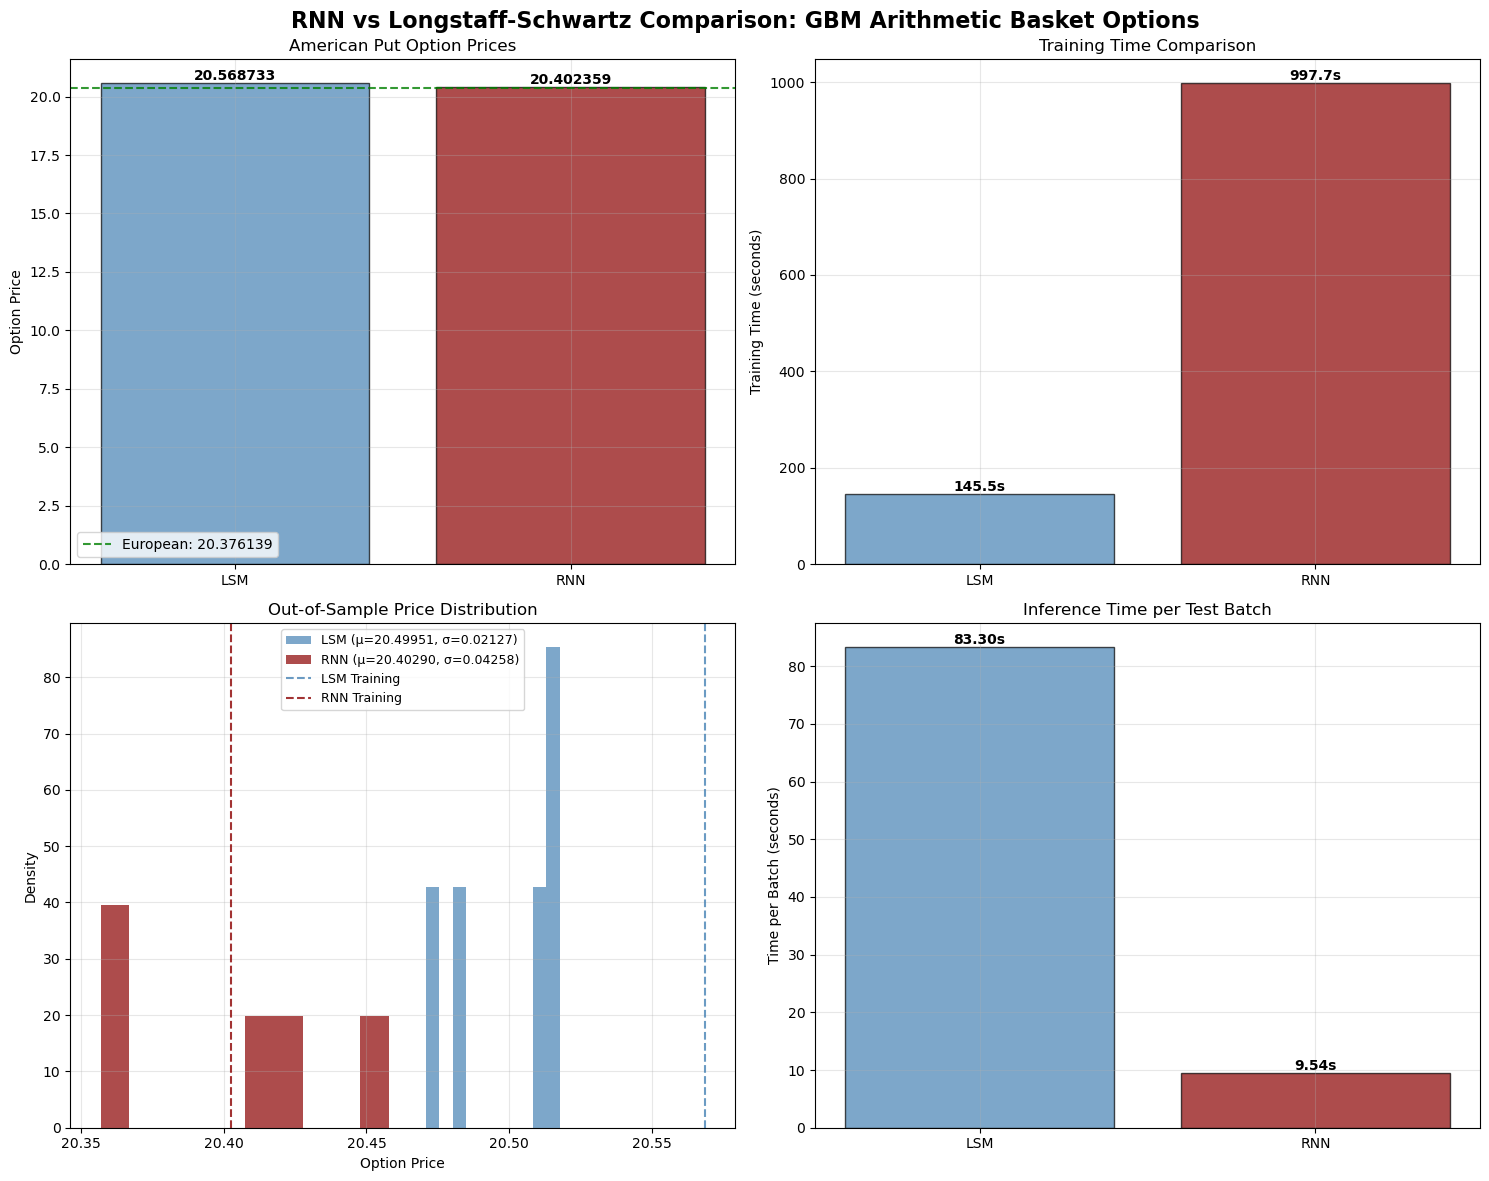


Detailed Statistics:
LSM Out-of-Sample Prices: [20.51772930921302, 20.515893385319423, 20.470862900642118, 20.510134439748324, 20.482928930439478]
RNN Out-of-Sample Prices: [20.411962509155273, 20.42433738708496, 20.363534927368164, 20.45793914794922, 20.356735229492188]

Price Stability:
LSM CV (σ/μ): 0.104%
RNN CV (σ/μ): 0.209%


In [8]:
# Create visualization comparing the two methods
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('RNN vs Longstaff-Schwartz Comparison: GBM Arithmetic Basket Options', fontsize=16, fontweight='bold')

# 1. Price Comparison
methods = ['LSM', 'RNN']
prices = [lsm_price, rnn_V0_cached]
colors = ['steelblue', 'darkred']

bars1 = ax1.bar(methods, prices, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Option Price')
ax1.set_title('American Put Option Prices')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, price in zip(bars1, prices):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{price:.6f}', ha='center', va='bottom', fontweight='bold')

# Add European price reference line
ax1.axhline(y=euro_price, color='green', linestyle='--', alpha=0.8, 
           label=f'European: {euro_price:.6f}')
ax1.legend()

# 2. Training Time Comparison
train_times = [lsm_train_time, rnn_train_time]
bars2 = ax2.bar(methods, train_times, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time Comparison')
ax2.grid(True, alpha=0.3)

for bar, time in zip(bars2, train_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

# 3. Out-of-Sample Price Distribution
ax3.hist(lsm_test_prices, bins=10, alpha=0.7, color='steelblue', 
         label=f'LSM (μ={lsm_mean_test:.5f}, σ={lsm_test_std:.5f})', density=True)
ax3.hist(rnn_test_prices, bins=10, alpha=0.7, color='darkred', 
         label=f'RNN (μ={rnn_mean_test:.5f}, σ={rnn_test_std:.5f})', density=True)
ax3.axvline(lsm_price, color='steelblue', linestyle='--', alpha=0.8, label='LSM Training')
ax3.axvline(rnn_V0_cached, color='darkred', linestyle='--', alpha=0.8, label='RNN Training')
ax3.set_xlabel('Option Price')
ax3.set_ylabel('Density')
ax3.set_title('Out-of-Sample Price Distribution')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Inference Time per Batch
test_times_per_batch = [lsm_test_time/len(test_seeds), rnn_test_time/len(test_seeds)]
bars4 = ax4.bar(methods, test_times_per_batch, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Time per Batch (seconds)')
ax4.set_title('Inference Time per Test Batch')
ax4.grid(True, alpha=0.3)

for bar, time in zip(bars4, test_times_per_batch):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nDetailed Statistics:")
print(f"LSM Out-of-Sample Prices: {lsm_test_prices}")
print(f"RNN Out-of-Sample Prices: {rnn_test_prices}")
print(f"\nPrice Stability:")
print(f"LSM CV (σ/μ): {lsm_test_std/lsm_mean_test*100:.3f}%")
print(f"RNN CV (σ/μ): {rnn_test_std/rnn_mean_test*100:.3f}%")